In [144]:
#Step 1: Import the data and coordinates 
#Step 2: Put coordinates into a dataframe and subsequently a geodataframe
#Step 3: Match the coordinates with the object ID (hives)
#Step 4: Project the shapefile and coordinates
#Step 5: Create a function to perform statistical analsysis on the elements
#Step 6: Put buffer around the beehives
#Step 7: Create a graduated symbols map of the point data

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import fiona
import os

#read shapefile
shapefile = gpd.read_file("./Superfund_Shape/Superfund_Shape.shp")

#read coordinate and elements data
hmsdf = pd.read_csv('./Heavy Metal Sheet-Final.csv')
denver = pd.read_csv('./denver.csv')
elementsdf = hmsdf.iloc[: , 3:12].copy()
coord = hmsdf.iloc[: , [12,13]].copy()
elnames = elementsdf.columns

#convert coordinates dataframe to geodataframe
coords_gdf = gpd.GeoDataFrame(coord, geometry=gpd.points_from_xy(hmsdf.Coordinate2, hmsdf.Coordinate1))
hms_gdf = gpd.GeoDataFrame(hmsdf, geometry=gpd.points_from_xy(hmsdf.Coordinate2, hmsdf.Coordinate1))
denvergdf = gpd.GeoDataFrame(denver)

def elstats (df, eldf):
  """
  Statistics for mean, median, etc. from a pandas dataframe that contains elemental data
  parameters:
    df: the name of the dataframe with the data
    eldf: list of the element names

  """
  mean = df.mean()
  stddev = df.std()
  max = df.max()
  min = df.min()
  
  for i in range(len(elnames)):
    print(f"{eldf[i]}: mean = {round(mean[i], 2)}, standard deviation = {round(stddev[i], 2)}, max = {round(max[i], 2)}, min = {round(min[i], 2)}")
  


elstats(elementsdf, elnames)

Cu: mean = 1.78, standard deviation = 0.66, max = 2.56, min = 0.47
Cd: mean = 0.53, standard deviation = 1.19, max = 1.91, min = -1.8
Fe: mean = 7.97, standard deviation = 4.54, max = 19.86, min = 4.1
Mg: mean = -0.77, standard deviation = 1.59, max = 2.64, min = -2.27
Ni: mean = 0.99, standard deviation = 0.32, max = 1.43, min = 0.61
Hg: mean = 1.47, standard deviation = 0.59, max = 2.39, min = 0.68
Ar: mean = -160.4, standard deviation = 174.94, max = 78.33, min = -532.67
Sn: mean = 30.17, standard deviation = 3.23, max = 36.35, min = 25.58
Sb: mean = 11.39, standard deviation = 1.2, max = 13.21, min = 9.68


In [149]:
denvergdf

,OID_,OBJECTID,COUNTYFP,Shape_Leng,Shape_Area,low,lowmod,LMMI,lowmoduniv,lowmod_pct,NAMELSAD10
0,16,17,31,2.744229,0.042103,214070.0,330205.0,441065.0,634420.0,0.520483,Denver County


In [35]:
#set the initial geodataframe crs
#WGS 84 / Pseudo-Mercator -- Spherical Mercator
coords_gdf.crs = "EPSG:3857"

#convert coordinates to a Colorado specific projection
shapefile = shapefile.to_crs("EPSG:3857")

#buffer for 3 miles in meters
buffer = coords_gdf.buffer(4828.03)
buffer = gpd.GeoDataFrame(gpd.GeoSeries(buffer))
buffer = buffer.rename(columns={0: 'geometry'})
buffer = buffer.set_geometry('geometry')

intersection = gpd.overlay(buffer, shapefile, how='intersection')

# intersection.to_file('sf_overlap.shp')

In [135]:
#create a geodataframe of only the superfund sites that intersect
superfund = []
for id1 in range(len(intersection)):
    for id2 in range(len(shapefile)):
        if shapefile['ID'][id2] == intersection['ID'][id1]:
            xy = shapefile['geometry'][id2]
            superfund.append(xy) 

superfunddf = pd.DataFrame(superfund)
superfunddf = superfunddf.rename(columns={0: 'geometry'})
superfundgdf = gpd.GeoDataFrame(superfunddf, geometry='geometry')


c:\Users\suwak\anaconda3\envs\geog5092\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


c:\Users\suwak\anaconda3\envs\geog5092\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\suwak\anaconda3\envs\geog5092\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\suwak\anaconda3\envs\geog5092\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\suwak\anaconda3\envs\geog5092\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


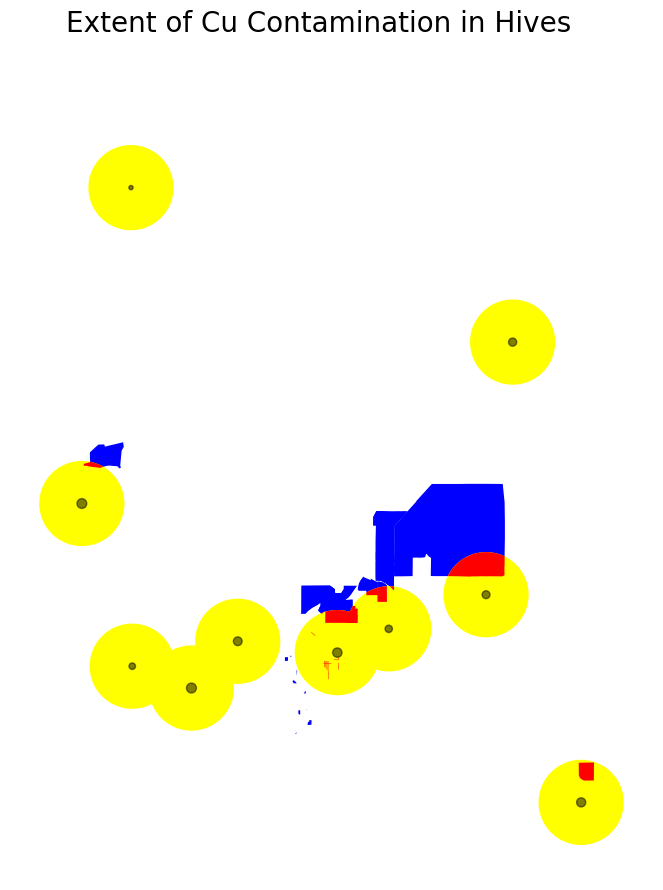

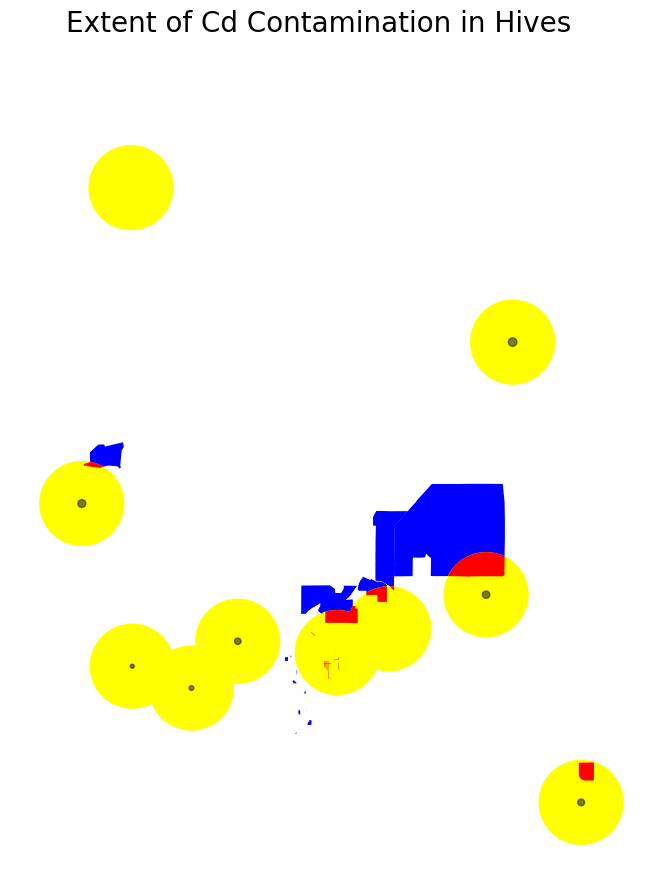

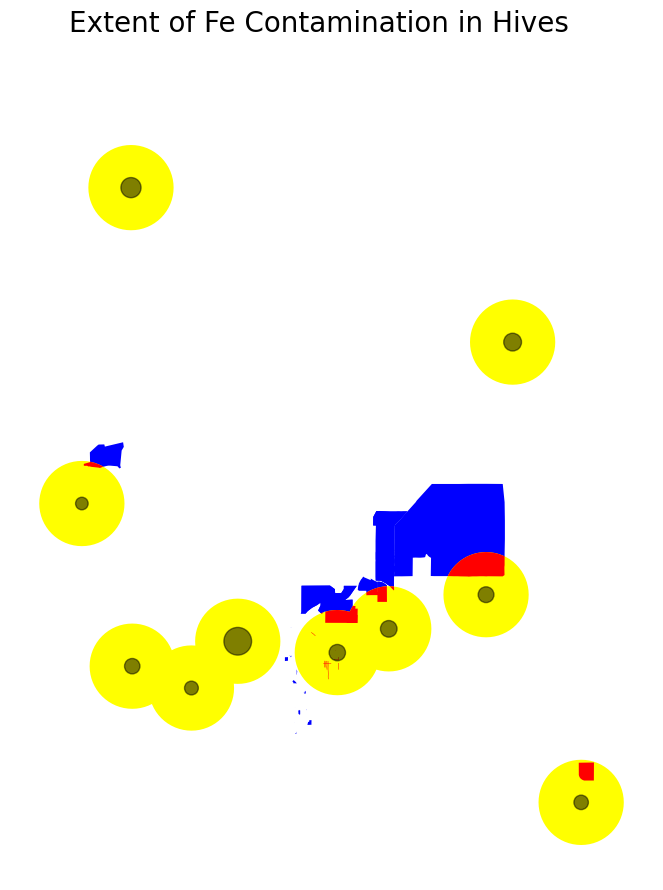

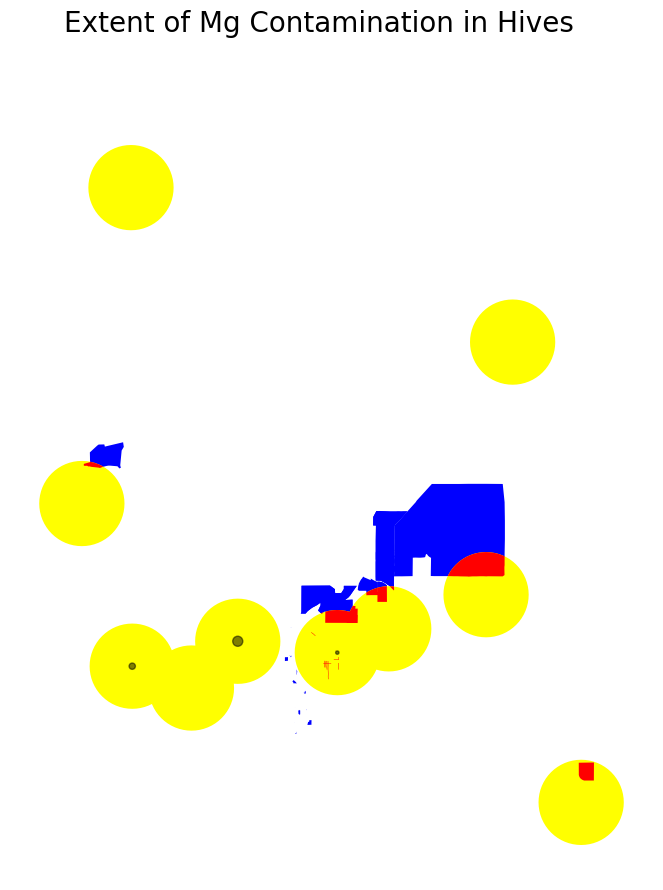

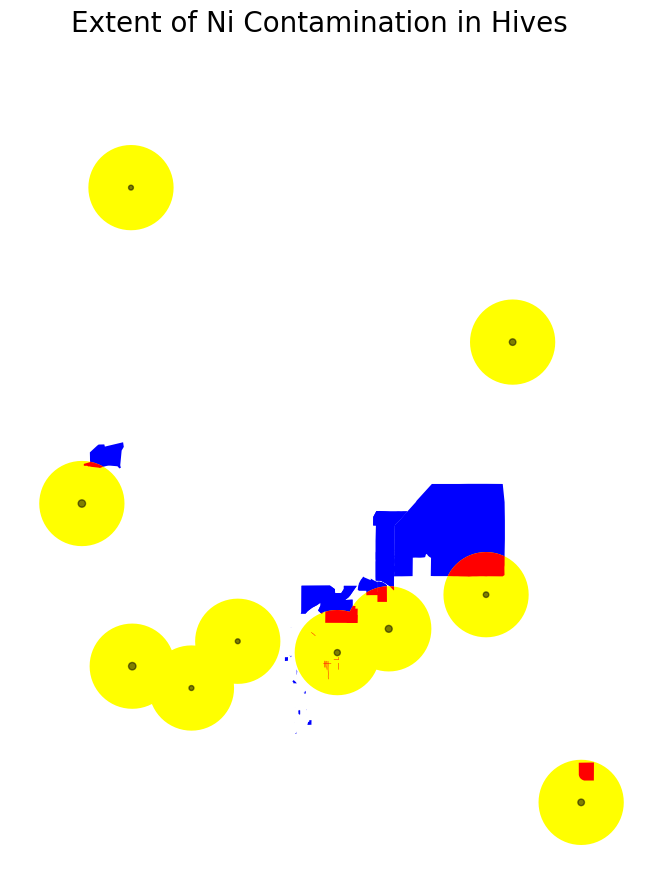

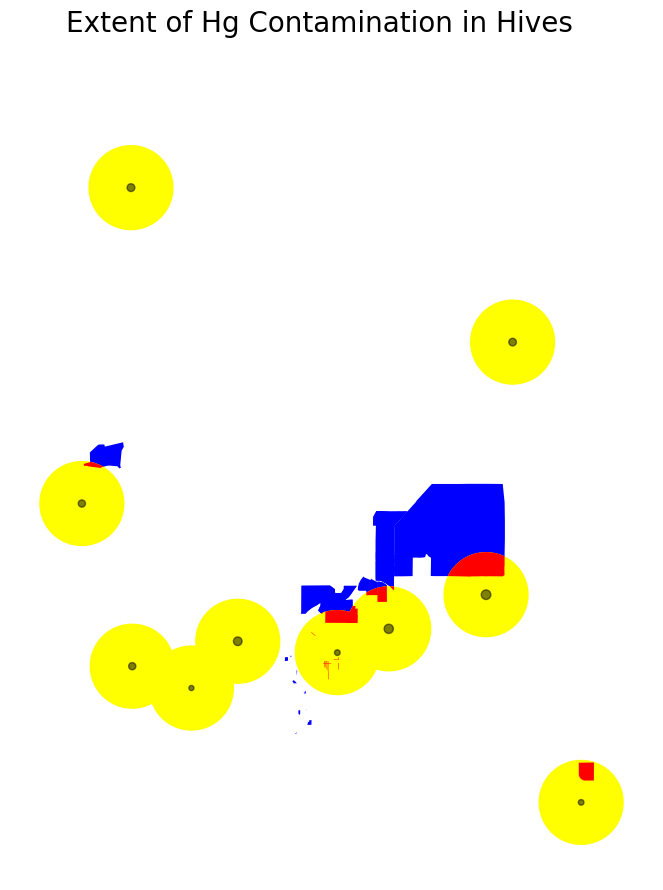

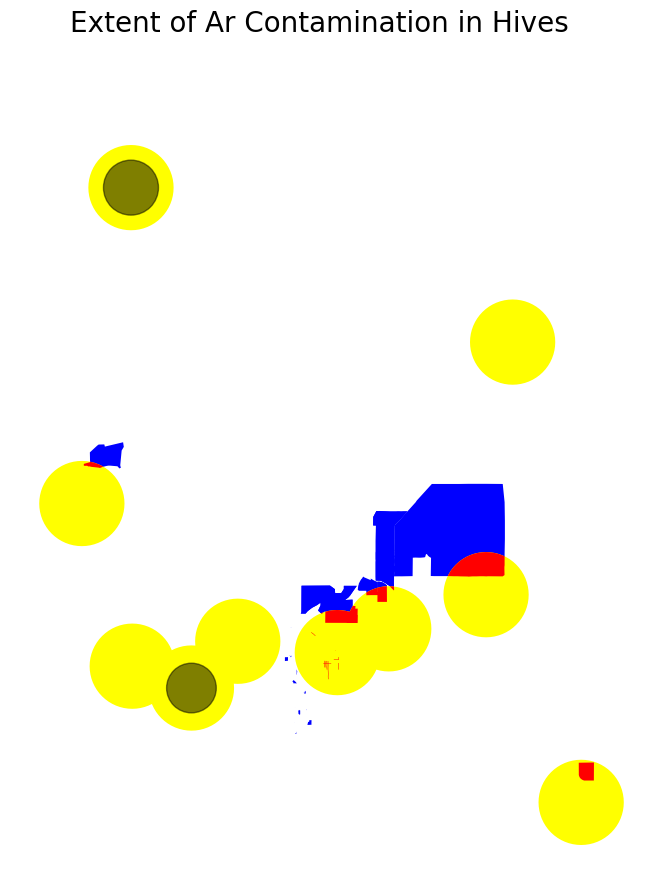

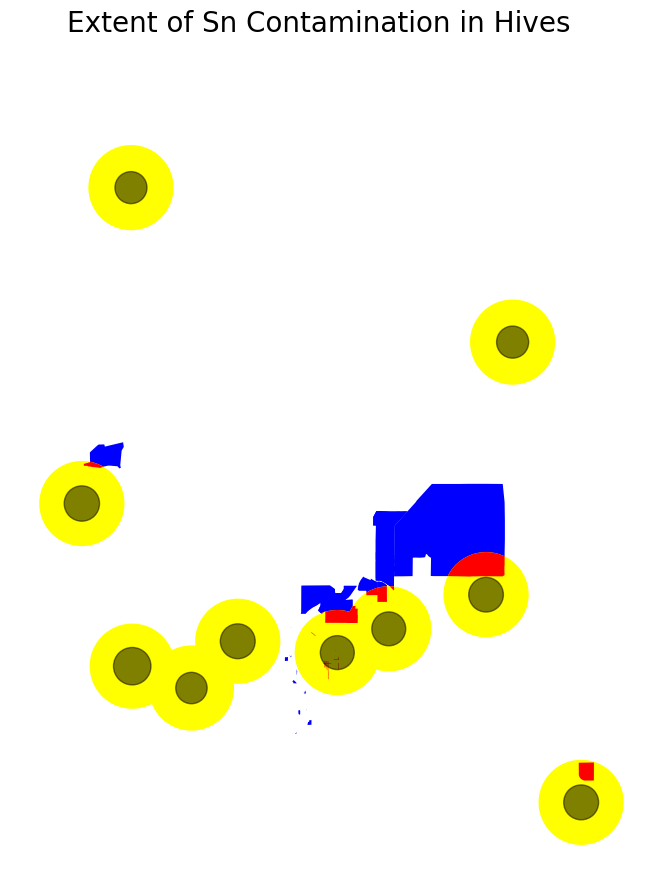

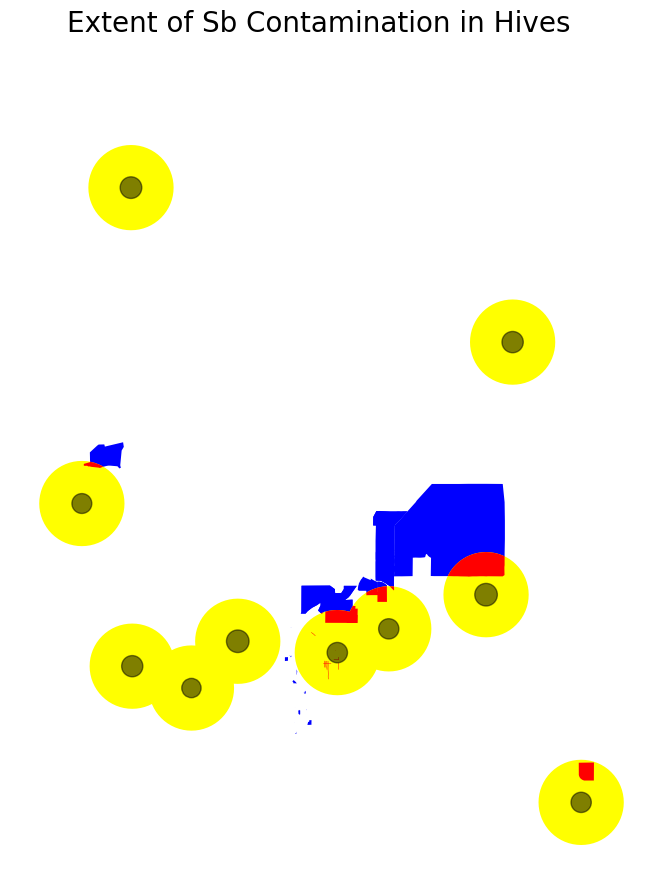

In [139]:
labels = ["Superfund Site", "Range of Hive", "Extent of Contamination"]
for el in elnames:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle(f'Extent of {el} Contamination in Hives', fontsize=20)
    ms = hms_gdf[el]
    superfundgdf.plot(ax=ax, color='blue')
    buffer.plot(ax=ax, color='yellow')
    intersection.plot(ax=ax, color='red')
    hms_gdf.plot(markersize=ms * 20, ax=ax, color='black', alpha=0.5)
    ax.set_axis_off()
